# Explore pybaseball

In [1]:
from pybaseball import playerid_lookup, statcast_pitcher, statcast_pitcher_spin
import pandas as pd
import datetime
import numpy as np

In [2]:
player = playerid_lookup('bauer', 'trevor')['key_mlbam'].values[0]

Gathering player lookup table. This may take a moment.


In [3]:
player

545333

In [4]:
player_stats = statcast_pitcher('2021-01-01', '2021-07-03', player)

Gathering Player Data


In [5]:
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pitch_type                       1787 non-null   object 
 1   game_date                        1787 non-null   object 
 2   release_speed                    1787 non-null   float64
 3   release_pos_x                    1787 non-null   float64
 4   release_pos_z                    1787 non-null   float64
 5   player_name                      1787 non-null   object 
 6   batter                           1787 non-null   int64  
 7   pitcher                          1787 non-null   int64  
 8   events                           431 non-null    object 
 9   description                      1787 non-null   object 
 10  spin_dir                         0 non-null      float64
 11  spin_rate_deprecated             0 non-null      float64
 12  break_angle_deprecat

In [6]:
player_stats[['player_name', 'pitch_type', 'release_speed', 'release_spin_rate']]

,player_name,pitch_type,release_speed,release_spin_rate
0,"Bauer, Trevor",SL,84.2,2878.0
1,"Bauer, Trevor",SI,97.4,2401.0
2,"Bauer, Trevor",SL,81.6,2835.0
3,"Bauer, Trevor",SL,81.3,2887.0
4,"Bauer, Trevor",SL,81.1,2729.0
...,...,...,...,...
1782,"Bauer, Trevor",FF,94.1,2700.0
1783,"Bauer, Trevor",FF,92.3,2694.0
1784,"Bauer, Trevor",FF,91.2,2671.0
1785,"Bauer, Trevor",FF,92.2,2736.0


In [7]:
# add SVR (=spinrate/speed)
player_stats['SVR'] = player_stats['release_spin_rate'] / player_stats['release_speed']
player_stats = player_stats[['player_name', 'pitch_type', 'game_date', 'SVR']]

In [8]:
# selct for pitches: FT, FF, CU, FC
#X = player_stats[player_stats['pitch_type'].isin(['FT', 'FF', 'CU', 'FC'])]
X = player_stats[player_stats['pitch_type'].isin(['FT', 'FF'])]

In [9]:
X.shape

(723, 4)

In [10]:
X.head()

,player_name,pitch_type,game_date,SVR
19,"Bauer, Trevor",FF,2021-06-28,26.900329
25,"Bauer, Trevor",FF,2021-06-28,26.856835
29,"Bauer, Trevor",FF,2021-06-28,25.509310
50,"Bauer, Trevor",FF,2021-06-28,27.730647
51,"Bauer, Trevor",FF,2021-06-28,27.622081


In [11]:
X2 = X[['game_date', 'SVR']].copy()
X2.sort_values(by='game_date', inplace=True)
X2.set_index('game_date', inplace=True)

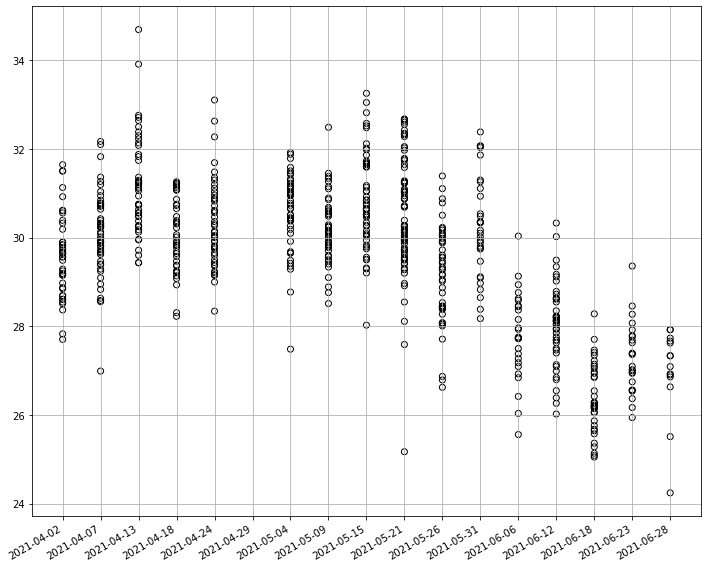

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X2.index.values, X2['SVR'], marker='o', edgecolor='k', facecolor='none')
#ax.set_ylim(25, 40)
ax.grid()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [13]:
def get_pitcher_data(last, first, start_dt, end_dt):
    # get player id
    playerdf = playerid_lookup(last, first)
    if playerdf.shape[0] == 0:
        return('No player named {}, {}'.format(last, first))
    playerid = playerdf['key_mlbam'].values[0]
    
    # get player stats
    player_stats = statcast_pitcher(start_dt, end_dt, playerid)
    player_stats['game_date'] = pd.to_datetime(player_stats['game_date'])
    
    # cull dataframe
    #    only fastballs
    player_stats = player_stats[player_stats['pitch_type'].isin(['FT', 'FF'])]
    #    calc spinrate velocity ratios (SVR) = spinrate/speed
    player_stats['SVR'] = player_stats['release_spin_rate'] / player_stats['release_speed']
    #    only spin stuff
    player_stats = player_stats[['player_name', 'pitch_type', 'game_date', 'SVR']]
    
    # sort and index
    player_stats.sort_values(by='game_date', inplace=True)
    player_stats.set_index('game_date', inplace=True)
    return(player_stats)

In [14]:
def plot_SVR(player_stats):
    """
    plot SVR vs date
    """
    player_name = player_stats['player_name'].values[0]
    fig, ax = plt.subplots(figsize=(14,8))
    ax.scatter(player_stats.index.values, player_stats['SVR'], marker='o', edgecolor='k', facecolor='none')
    ax.set_ylim(20, 35)
    ax.set_title(player_name)
    ax.set_ylabel('Spin-Velocity Ratio')
    ax.set_xlabel('date')
    ax.grid()
    #plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [15]:
def plot_SVR_boxplot(player_stats, treatment_datestr='2021-06-03'):
    """
    plot boxplots of SVR before and after treatment
    player_stats: df
    treatment_date: str (%Y-%m-%d')
    """
    # prepare data
    treatment_date = datetime.datetime.strptime(treatment_datestr, '%Y-%m-%d')
    before = [i for i in player_stats['SVR'].truncate(after=treatment_date).values if not np.isnan(i)]
    after = [i for i in player_stats['SVR'].truncate(before=treatment_date).values if not np.isnan(i)]
    data = [before, after]
    player_name = player_stats['player_name'].values[0]

    # plot
    fig, ax = plt.subplots(figsize=(3, 8))
    ax.boxplot(data, showfliers=False, notch=True, bootstrap=5000, widths=0.5)
    ax.set_xticklabels(labels=['before {}'.format(treatment_datestr), 'after'])
    ax.set_ylabel('SVR')
    ax.set_title(player_name)
    plt.show()

Gathering Player Data


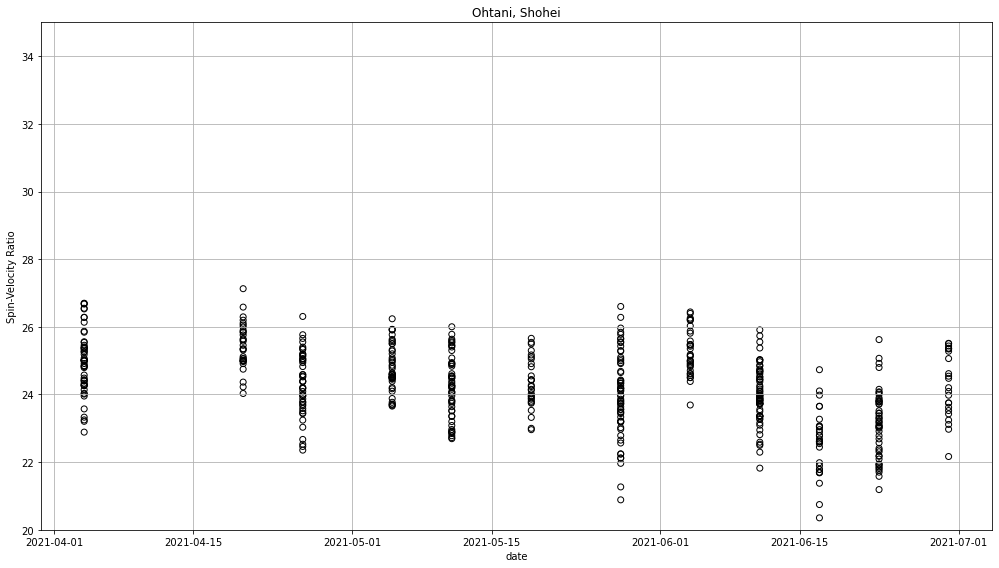

In [16]:
player_stats = get_pitcher_data('Ohtani', 'Shohei', '2021-01-01', '2021-07-05')
plot_SVR(player_stats)

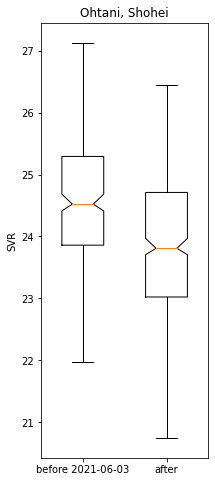

In [17]:
plot_SVR_boxplot(player_stats)